### Post–Earnings Announcement Drift

There is no surprise that an earnings announcement will move stock price. It is, however, surprising that this move will persist for some time after the announcement, and in the same direction, allowing momentum traders to benefit. Even more surprising is that though this fact has been known and studied since 1968 ([Bernard and Thomas, 1989](https://www.jstor.org/stable/2491062)), the effect still has not been arbitraged away, though the duration of the drift may have shortened.What I will show in this section is that as recently as 2011 this strategy is still profitable if we enter at the market open after the earnings announcement was made after the previous close, buying the stock if the return is very positive and shorting if the return is very negative, and liquidate the position at the same day’s close. Notice that this strategy does not require the trader to interpret whether the earnings announcement is “good” or “bad.” It does not even require the trader to know whether the earnings are above or below analysts’ expectations. We let the market tell us whether it thinks the earnings are good or bad.

### Example 7.2: Backtest of Post-Earnings Announcement Drift Strategy

We assume the historical open and close prices are stored in the *T × N* arrays *op* and *cl*. The input *T × N* logical array earnann indicates whether there is an earnings announcement for a stock on a given day prior to that day’s market open but after the previous trading day’s market close. The backtest program itself is named [pead.py](https://github.com/usunyu/quant-for-fortune/blob/main/Algorithmic%20Trading%20-%20Winning%20Strategies%20and%20Their%20Rationale/pead.py).

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

<Axes: xlabel='January 3, 2011, to April 24, 2012', ylabel='Cumulative Returns'>

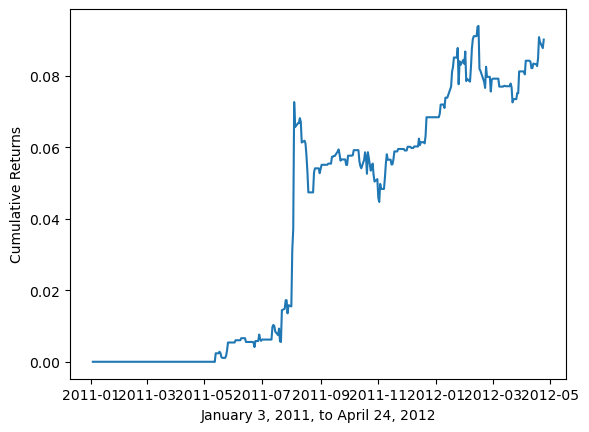

In [2]:
op=pd.read_csv('inputDataOHLCDaily_20120424_op.csv')
cl=pd.read_csv('inputDataOHLCDaily_20120424_cl.csv')

stocks=pd.read_csv('inputDataOHLCDaily_20120424_stocks.csv')

# remove HH:MM:SS
op['Var1']=pd.to_datetime(op['Var1'],  format='%Y%m%d').dt.date
op.columns=np.insert(stocks.values, 0, 'Date')
op.set_index('Date', inplace=True)

# remove HH:MM:SS
cl['Var1']=pd.to_datetime(cl['Var1'],  format='%Y%m%d').dt.date
cl.columns=np.insert(stocks.values, 0, 'Date')
cl.set_index('Date', inplace=True)

earnann=pd.read_csv('earnannFile.csv')
# remove HH:MM:SS
earnann['Date']=pd.to_datetime(earnann['Date'],  format='%Y%m%d').dt.date
earnann.set_index('Date', inplace=True)

np.testing.assert_array_equal(stocks.iloc[0,:], earnann.columns)

df=pd.merge(op, cl, how='inner', left_index=True, right_index=True, suffixes=('_op', '_cl'))
df=pd.merge(earnann, df, how='inner', left_index=True, right_index=True)

earnann=df.iloc[:, 0:(earnann.shape[1])].astype(bool)
op=df.iloc[:, (earnann.shape[1]):((earnann.shape[1])+op.shape[1])]
cl=df.iloc[:, ((earnann.shape[1])+op.shape[1]):]

op.columns=stocks.iloc[0,:]
cl.columns=stocks.iloc[0,:]

lookback=90

retC2O=(op-cl.shift())/cl.shift()
stdC2O=retC2O.rolling(lookback).std()

positions=np.zeros(cl.shape) 

longs=  (retC2O >=  0.5*stdC2O) & earnann
shorts= (retC2O <= -0.5*stdC2O) & earnann

positions[longs]=1
positions[shorts]=-1

ret=np.sum(positions*(cl-op)/op, axis=1)/30

cumret=(np.cumprod(1+ret)-1)
cumret.plot(
    xlabel='January 3, 2011, to April 24, 2012',
    ylabel='Cumulative Returns'
)

**FIGURE 7.2** Cumulative Returns Curve of PEAD Strategy

In [3]:
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))

APR=0.068126 Sharpe=1.494743
Max DD=-0.026052 Max DDD in days=109


For a universe of S&P 500 stocks, the APR from January 3, 2011, to April 24, 2012, is 6.7 percent, while the Sharpe ratio is a very respectable 1.5. The cumulative returns curve is displayed in Figure 7.2. Note that we have used 30 as the denominator in calculating returns, since there is a maximum of 30 positions in one day during that backtest period. Of course, there is a certain degree of look-ahead bias in using this number, since we don’t know exactly what the maximum will be. But given that the maximum number of announcements per day is quite predictable, this is not a very grievous bias. Since this is an intraday strategy, it is possible to lever it up by at least four times, giving an annualized average return of close to 27 percent.

You might wonder whether holding these positions overnight will generate additional profits. The answer is no: the overnight returns are negative on average. On the contrary, many published results from 10 or 20 years ago have shown that PEAD lasted more than a day. This may be an example where the duration of momentum is shortened due to increased awareness of the existence of such momentum. It remains to be tested whether an even shorter holding period may generate better returns.